<a href="https://colab.research.google.com/github/VSUrhuel/forage-classifier/blob/main/%5B2025-05-10%5Dtraining_without_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from google.colab import drive
import cv2
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
drive.mount('/content/drive')
path_to_dataset = '/content/drive/MyDrive/Thesis/Dataset'

Mounted at /content/drive


In [3]:
classes = ['carabao-grass', 'centro', 'gliricidia', 'leucaena', 'para-grass']

X_train, Y_train = [], []
is_augmented = []
X_val, Y_val = [], []
X_test, Y_test = [], []

def assign_index_label(forage_type):
  forage_type = forage_type.lower()
  if forage_type in classes:
    return classes.index(forage_type)
  else:
    print("Unrecognized forage label")
    return -1

In [4]:
def load_dataset_from_folder(path, X, Y):
  for forage_type in os.listdir(path):
    forage_path = os.path.join(path, forage_type)

    label = assign_index_label(forage_type)
    for image in os.listdir(forage_path):
      image_path = os.path.join(forage_path, image)\

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0

      if(image_path.find('aug') != -1):
        is_augmented.append(True)
      else:
        is_augmented.append(False)
      X.append(image)
      Y.append(label)

In [5]:
train_dir = os.path.join(path_to_dataset, 'train')
val_dir = os.path.join(path_to_dataset, 'val')
test_dir = os.path.join(path_to_dataset, 'test')

load_dataset_from_folder(train_dir, X_train, Y_train)
load_dataset_from_folder(val_dir, X_val, Y_val)
load_dataset_from_folder(test_dir, X_test, Y_test)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, len(classes))
Y_val = to_categorical(Y_val, len(classes))
Y_test = to_categorical(Y_test, len(classes))

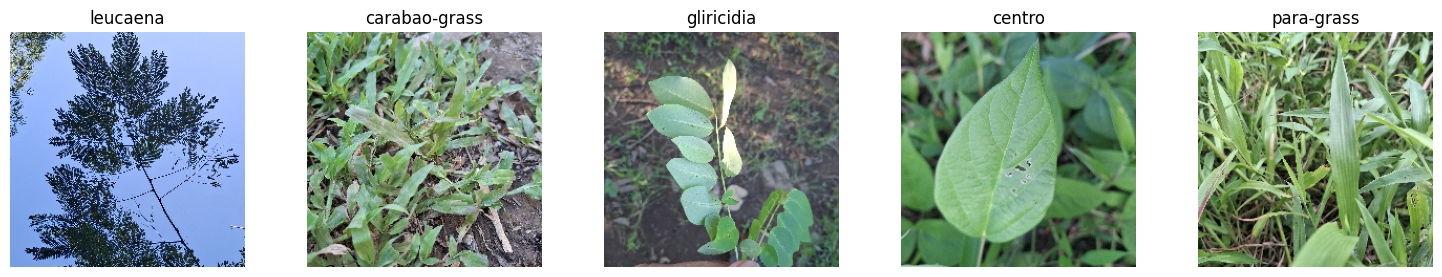

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
fig.tight_layout()
selected_indices = []

# Get 10 random samples (2 per class for 5 classes)
for cls in range(len(classes)):
    # Find all indices where this class appears in TEST set
    class_indices = np.where(np.argmax(Y_test, axis=1) == cls)[0]

    random_indices = random.sample(list(class_indices), 1)
    selected_indices.extend(random_indices)

random.shuffle(selected_indices)

# Plot the selected samples
for ind, idx in enumerate(selected_indices[:5]):
    ax[ind].imshow(X_test[idx])
    ax[ind].set_title(f"{classes[np.argmax(Y_test[idx])]}")
    ax[ind].axis('off')

plt.show()

In [ ]:
model = Sequential()
# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))


# Top layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))


model.add(Dense(5, activation = "softmax"))


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_128 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_124               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_125               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_126               │ (None, 14, 14, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,270,917 (50.62 MB)

 Trainable params: 13,270,917 (50.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Thesis/Dataset/new_best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)


history = model.fit(
    X_train,
    Y_train,
    epochs=150,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.2193 - loss: 1.8009 - val_accuracy: 0.2373 - val_loss: 1.5601
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2502 - loss: 1.5203 - val_accuracy: 0.4068 - val_loss: 1.4832
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2955 - loss: 1.4607 - val_accuracy: 0.4237 - val_loss: 1.3563
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3464 - loss: 1.4357 - val_accuracy: 0.4407 - val_loss: 1.1768
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4618 - loss: 1.2527 - val_accuracy: 0.5593 - val_loss: 1.2134
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.4906 - loss: 1.2022 - val_accuracy: 0.5085 - val_loss: 1.1515
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4699 - loss: 1.2623 - val_accuracy: 0.5932 - val_loss: 1.0589
Epoch 8/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5365 - loss: 1.0954 - val_accuracy: 

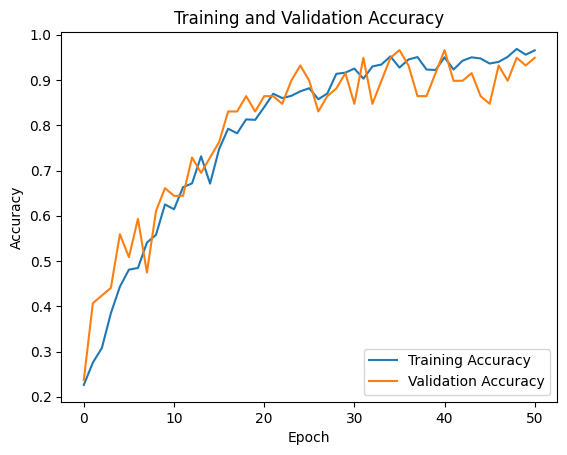

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9973 - loss: 0.0466


In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()
test_loss, test_acc = model.evaluate(X_train, Y_train)

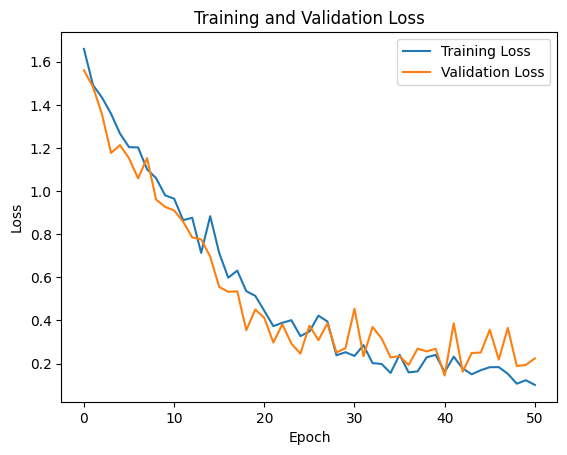

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9670 - loss: 0.1475


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [11]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/Dataset/new_best_model.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")

# THIS IS CODE IS JUST FOR CHECKING THE MISCLASSIFIED DATA
# for i, img in enumerate(X_test):
#     pred = model.predict(np.expand_dims(img, axis=0), verbose=0)

#     pred_label = np.argmax(pred[0])
#     true_label = np.argmax(Y_test[i])

#     if pred_label != true_label:
#         plt.imshow(img)
#         plt.title(f"Predicted: {classes[pred_label]} | Actual: {classes[true_label]}")
#         plt.axis('off')
#         plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.9787 - loss: 0.1730
Final Test Accuracy: 0.98


In [7]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


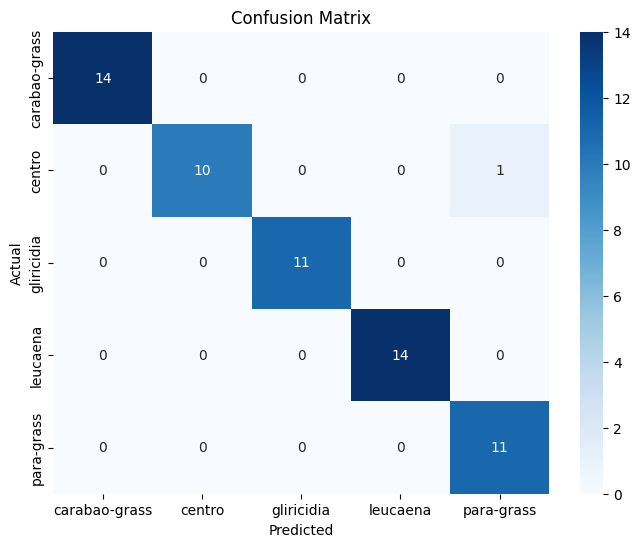

In [8]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:

from tabulate import tabulate

def display_results(train_history, test_acc, val_acc):
    """Display model results in a formatted table"""

    # Get metrics
    train_acc = train_history.history['accuracy'][-1]
    best_val_acc = max(train_history.history['val_accuracy'])
    acc_gap = train_acc - best_val_acc
    best_epoch = np.argmax(train_history.history['val_accuracy']) + 1

    table = [
        ["Metric", "Value", "Status"],
        ["Training Accuracy", f"{train_acc:.2%}"],
        ["Validation Accuracy", f"{best_val_acc:.2%}"],
        ["Test Accuracy", f"{test_acc:.2%}"],
        ["Accuracy Gap", f"{acc_gap:.2%}"],
        ["Best Epoch", best_epoch, ]
    ]

    # Print results
    print("\n" + "="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)
    print(tabulate(table, headers="firstrow", tablefmt="grid"))


In [ ]:
display_results(history, test_acc, val_acc)

In [10]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/Dataset/new_best_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Thesis/Dataset/new_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp00aegtej'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_32')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133106007680272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007681616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007681424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007683344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007682576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007684496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007684688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007686032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007685264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007686800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133106007686